In [1]:
import tweepy # extract tweeter data
import pandas as pd # data manipulation
import numpy as np # data manipulation 
import contractions # expand contractions
import re # regular expressions
import string # count-based features
import matplotlib.pyplot as plt # visualization

from textblob import TextBlob # sentiment analysis
from wordcloud import WordCloud # visualization
from nltk.tokenize import word_tokenize # tokenize string or sentences
from nltk.corpus import stopwords # import english stopword list
from nltk.stem import PorterStemmer # stemming
from collections import Counter # count occurences

plt.style.use('fivethirtyeight') # plot style

In [ ]:
# get the data
keys = pd.read_csv('twitter_keys.csv', header=None)

In [3]:
# assign secret keys to labels
CONSUMER_TOKEN = keys.iloc[0][1].lstrip()
CONSUMER_TOKEN_SECRET = keys.iloc[1][1].lstrip()
BEARER_TOKEN = keys.iloc[2][1].lstrip()
ACCESS_TOKEN = keys.iloc[3][1].lstrip()
ACCESS_TOKEN_SECRET = keys.iloc[4][1].lstrip()

In [4]:
# create auth object
authenticate = tweepy.OAuthHandler(CONSUMER_TOKEN, CONSUMER_TOKEN_SECRET)

# set access token and access token secret
authenticate.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

# create API object
api = tweepy.API(authenticate, wait_on_rate_limit=True)

In [5]:
# extract tweets
posts = api.search_tweets(q=['Putin'], count=100, lang='en', tweet_mode='extended')

i = 1
# print first 5 posts
for tweet in posts[:5]:
    print(str(i) + ') ' + tweet.full_text + '\n')
    i += 1

1) RT @NeilPHauer: Something I've noticed over the past week or so here: almost every Ukrainian I spoke to has made it clear that they blame n…

2) RT @ThinkJoMice: Dear Helen:

You must be talking about the location of the former Romanov palace because the video is clear, Putin's Palac…

3) RT @mikegalsworthy: @BenQuinn75 Comparing Brexit to the Ukrainian fight for freedom - and thereby likening the EU to Putin - is hardly bril…

4) RT @ozii_baba: This is the condition he left Onitsha to relocate to USA. This is Onitsha. The commercial capital of Africa. 

For years, it…

5) RT @LatestAnonPress: This is what Putin calls a "special military operation"

#FCKPTN #StandWithUkraine https://t.co/dw7OiIcofZ



In [6]:
# create dataframe
df = pd.DataFrame([tweet.full_text for tweet in posts], columns=['Tweets'])

# show first 5 rows
df.head()

,Tweets
0,RT @NeilPHauer: Something I've noticed over th...
1,RT @ThinkJoMice: Dear Helen:\n\nYou must be ta...
2,RT @mikegalsworthy: @BenQuinn75 Comparing Brex...
3,RT @ozii_baba: This is the condition he left O...
4,RT @LatestAnonPress: This is what Putin calls ...


In [7]:
df.iloc[0,0]

"RT @NeilPHauer: Something I've noticed over the past week or so here: almost every Ukrainian I spoke to has made it clear that they blame n…"

In [8]:
# load stopwords default nltk list
stop_words = stopwords.words('english')

def normalize_document(doc):
    """Normalize the document by performing basic text pre-processing tasks."""

    # remove HTML
    doc = re.sub(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$', '', doc)
    # remove special characters
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    # remove RT (retweets)
    doc = re.sub(r'RT[\s]', '', doc)
    # remove trailing whitespace
    nowhite = doc.strip()
    # expand contractions
    expanded = contractions.fix(nowhite)
    # tokenize document
    tokens = word_tokenize(expanded)
    # remove stopwords
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from tokens
    doc = ' '.join(filtered_tokens)
    
    return doc

# vectorize function for faster computations
normalize_corpus = np.vectorize(normalize_document)

In [9]:
text_normalized = pd.DataFrame(normalize_corpus(df['Tweets']), columns=['Tweet'])
text_normalized.head()

,Tweet
0,NeilPHauer Something I Have noticed past week ...
1,ThinkJoMice Dear Helen You must talking locati...
2,mikegalsworthy BenQuinn75 Comparing Brexit Ukr...
3,oziibaba This condition left Onitsha relocate ...
4,LatestAnonPress This Putin calls special milit...


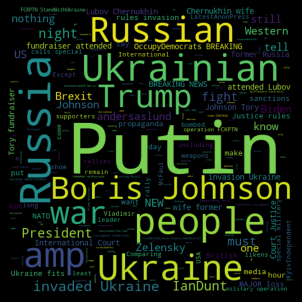

In [10]:
# generate wordcloud
wordcloud = WordCloud(width=512, height=512).generate(' '.join(text_normalized['Tweet']))
plt.figure(figsize=(6, 4), facecolor='k')
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [11]:
text_normalized.iloc[0,0]

'NeilPHauer Something I Have noticed past week almost every Ukrainian I spoke made clear blame n'

In [12]:
# get subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# get polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

# create a column for polarity scores
text_normalized['Polarity'] = text_normalized['Tweet'].apply(getSubjectivity)
# create a column for subjectivity scores
text_normalized['Subjectivity'] = text_normalized['Tweet'].apply(getPolarity)

In [13]:
# show first 5 rows
text_normalized.head()

,Tweet,Polarity,Subjectivity
0,NeilPHauer Something I Have noticed past week ...,0.316667,-0.075000
1,ThinkJoMice Dear Helen You must talking locati...,0.191667,0.050000
2,mikegalsworthy BenQuinn75 Comparing Brexit Ukr...,0.541667,-0.291667
3,oziibaba This condition left Onitsha relocate ...,0.000000,0.000000
4,LatestAnonPress This Putin calls special milit...,0.335714,0.128571


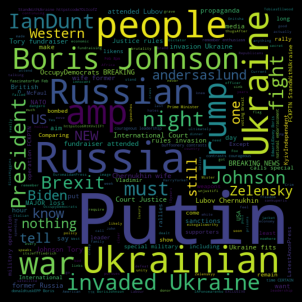

In [14]:
# generate wordcloud
wordcloud = WordCloud(width=512, height=512).generate(' '.join(text_normalized['Tweet']))
plt.figure(figsize=(6, 4), facecolor='k')
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [32]:
# analyze polarity results
def polarity_analysis(score):
    if score <= -0.3:
        return 'Negative'
    elif score >= 0.3:
        return 'Positive'
    else: # -0.3 < score < 0.3
        return 'Neutral'
    
# analyze subjectivity results
def subjectivity_analysis(score):
    if score < 0.5:
        return 'Objective'
    elif score > 0.5:
        return 'Subjective'
    elif score == 0.5:
        return 'Neutral'
    
# create new columns
text_normalized['Polarity_Tag'] = text_normalized['Polarity'].apply(polarity_analysis)
text_normalized['Subjectivity_Tag'] = text_normalized['Subjectivity'].apply(subjectivity_analysis)

In [33]:
# show first 5 rows
text_normalized.head()

,Tweet,Polarity,Subjectivity,Polarity_Tag,Subjectivity_Tag
0,NeilPHauer Something I Have noticed past week ...,0.316667,-0.075000,Positive,Objective
1,ThinkJoMice Dear Helen You must talking locati...,0.191667,0.050000,Neutral,Objective
2,mikegalsworthy BenQuinn75 Comparing Brexit Ukr...,0.541667,-0.291667,Positive,Objective
3,oziibaba This condition left Onitsha relocate ...,0.000000,0.000000,Neutral,Objective
4,LatestAnonPress This Putin calls special milit...,0.335714,0.128571,Positive,Objective


In [34]:
# create function to plot counts
def plot_counts(series):
    # check counts
    series_counts = Counter(series)
    # extract labels and counts
    labels = [key for key in series_counts.keys()]
    counts = [value for value in series_counts.values()]
    # plot barchart
    plt.bar(labels, counts)
    return plt.show()

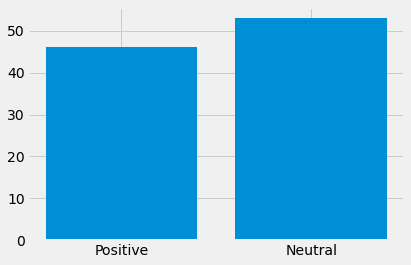

In [35]:
# plot polarity counts
plot_counts(text_normalized['Polarity_Tag'])

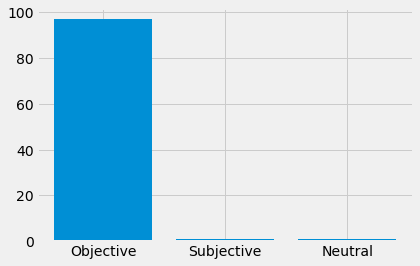

In [36]:
# plot subjectivity counts
plot_counts(text_normalized['Subjectivity_Tag'])

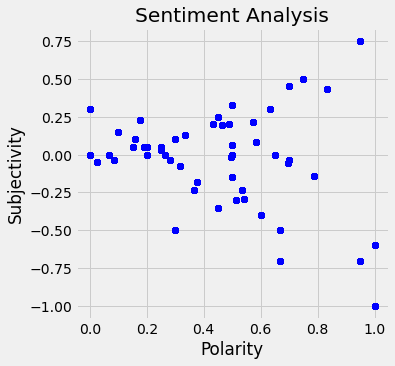

In [37]:
# plot polarity vs subjectivity
plt.figure(figsize=(5,5))
for i in range(text_normalized.shape[0]):
    plt.scatter(text_normalized.Polarity, text_normalized.Subjectivity, color='Blue')
    
plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

In [38]:
# get % of positive tweets
ptweets = text_normalized[text_normalized.Polarity_Tag=='Positive']
pol_pos = round( len(ptweets) / text_normalized.shape[0] * 100, 2)
# get % of subjective tweets
subj_tweets = text_normalized[text_normalized.Subjectivity_Tag=='Subjective']
subj_subj = round( len(subj_tweets) / text_normalized.shape[0] * 100, 2)
# get % of objective tweets
obj_tweets = text_normalized[text_normalized.Subjectivity_Tag=='Objective']
subj_obj = round( len(obj_tweets) / text_normalized.shape[0] * 100, 2)

print(f'Positive: {pol_pos}\nNeutral: {100-pol_pos}\n\n\
Subjective: {subj_subj}\nObjective: {subj_obj}\nNeutral: {round(100-(subj_subj+subj_obj), 2)}')

Positive: 46.46
Neutral: 53.54

Subjective: 1.01
Objective: 97.98
Neutral: 1.01
